In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np 
from numpy import log
import gmaps 
import gmaps.datasets 
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('ggplot')
from sorted_months_weekdays import Month_Sorted_Month
from statsmodels.tsa.stattools import adfuller

from statsmodels.tools.data import _is_using_pandas
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.statespace.kalman_filter import MEMORY_CONSERVE
from statsmodels.tsa.statespace.tools import diff
import statsmodels.base.wrapper as wrap
import statsmodels.api
import statsmodels as sm
import statsmodels.api as sm

<h4>Read in electrical consumption and population data</H4>

In [2]:
# read in electricity consumption data
electricity_df = pd.read_csv('data/GRU_Customer_Electric_Consumption.csv')

In [3]:
# read in population data for the city of Gainesville
population_df = pd.read_csv('./data/population.csv')
pd.set_option('display.max_rows', 500)

<H4>Create an electrical consumption df with date as the index</H4>

In [4]:
# Set Date column as index in population dataframe
population_df.set_index(['Date'])
pd.set_option('display.max_rows', 500)

In [5]:
# Convert dates into datetime format
electricity_df['Date'] = pd.to_datetime(electricity_df['Date'])

In [6]:
len(electricity_df['Service Address'].unique())

100313

<H4>Create a feature column for monthly average consumption per capita</H4>

In [7]:
# Groupby date of electrical consumption and aggregate values by mean for each date

grouped_e_df = electricity_df.groupby('Date', dropna=True, sort=True).agg(sum)
pd.set_option('display.max_rows', 500)

In [8]:
# join the popluation dataframe with the average monthly dataframe
pop_e_df = grouped_e_df.join(population_df.set_index('Date'), how='left', lsuffix='_left', rsuffix='_right')
pop_e_df = pop_e_df.drop('Year_right', axis=1)
pop_e_df = pop_e_df.rename(columns={'Year_left': 'Year'})

In [9]:
# add column with electricity use per capita 
pop_e_df['avg_kwh_capita'] = pop_e_df['KWH Consumption'] / pop_e_df['Population']

In [10]:
pop_e_df.describe()

,Year,KWH Consumption,Latitude,Longitude,Population,avg_kwh_capita
count,1.060000e+02,1.060000e+02,1.060000e+02,1.060000e+02,106.000000,106.000000
mean,1.766964e+08,1.385447e+08,2.599362e+06,-7.220154e+06,130890.518868,1058.961708
std,3.062499e+07,3.581049e+07,4.500482e+05,1.250076e+06,2934.605677,270.919477
min,6.807400e+05,1.200744e+06,9.994220e+03,-7.837485e+06,126038.000000,8.898025
25%,1.776347e+08,1.231004e+08,2.616549e+06,-7.605558e+06,128474.000000,928.480533
50%,1.810624e+08,1.336461e+08,2.663419e+06,-7.398104e+06,131593.000000,1012.639302
75%,1.862341e+08,1.605149e+08,2.738159e+06,-7.267901e+06,133851.000000,1219.563532
max,1.921969e+08,2.236522e+08,2.821585e+06,-2.774835e+04,134945.000000,1699.575008


<H4>Plot annual electrical consumption for each observation year</H4>

Text(0.5, 1.0, 'Gainesville, FL KWH per Capita 2012-2020')

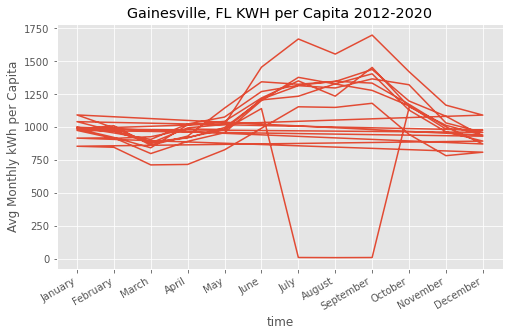

In [11]:
# Plot annual electrical consumption for all years
x = pop_e_df['Month']
y = pop_e_df['avg_kwh_capita']

fig, ax = plt.subplots(figsize=(8, 5))
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right', which='major')
plt.plot(x, y)
ax.set_xlabel('time')
ax.set_ylabel('Avg Monthly kWh per Capita')
ax.set_title('Gainesville, FL KWH per Capita 2012-2020')

<H4>Plot monthly average electrical consumption across observation period</H4>

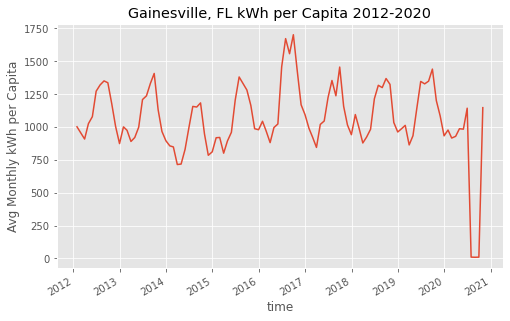

In [12]:
# plot historical consumption for years in sequence 

x = pop_e_df.index
y = pop_e_df['avg_kwh_capita']

fig, ax = plt.subplots(figsize=(8, 5))
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right', which='major')
plt.plot(x, y)
ax.set_xlabel('time')
ax.set_ylabel('Avg Monthly kWh per Capita')
ax.set_title('Gainesville, FL kWh per Capita 2012-2020')
plt.savefig('images/kWh_per_capita_diff.png')

In [36]:
pop_e_df

,Year,KWH Consumption,Latitude,Longitude,Month,Population,avg_kwh_capita
Date,,,,,,,
2012-01-31,176701888,126054114.0,2.604419e+06,-7.234198e+06,January,126038,1000.127850
2012-02-28,176929244,120538619.0,2.607771e+06,-7.243507e+06,February,126038,956.367278
2012-03-31,176615372,114328052.0,2.603140e+06,-7.230683e+06,March,126038,907.091925
2012-04-30,177090204,129050085.0,2.610144e+06,-7.250098e+06,April,126038,1023.898229
2012-05-31,176907112,135740489.0,2.607444e+06,-7.242611e+06,May,126038,1076.980665
2012-06-30,177070084,160150785.0,2.609849e+06,-7.249277e+06,June,126038,1270.654763
2012-07-31,176349788,166117321.0,2.599230e+06,-7.219809e+06,July,126038,1317.993946
2012-08-31,177633444,169991653.0,2.618150e+06,-7.272335e+06,August,126038,1348.733342
2012-09-30,174484664,168221038.0,2.571697e+06,-7.143533e+06,September,126038,1334.685079


<H4>Plot distribution of values to identity potential anomalies</H4>

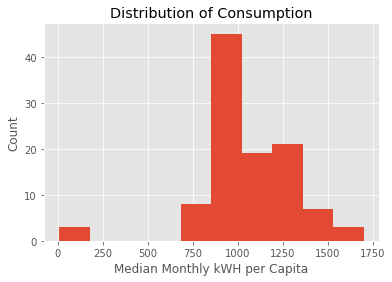

In [13]:
# Checking for stationarity by Summary Statistics

pop_e_df['avg_kwh_capita'].hist()
plt.xlabel('Median Monthly kWH per Capita')
plt.ylabel('Count')
plt.title('Distribution of Consumption')
plt.savefig('images/med_count_hist_diff.png')

<H4>Test for stationarity through summary statistics and augmented Dickey–Fuller test </H4>

In [14]:
# calculate summary statistics for above median consumption for stationarity

series = pop_e_df['avg_kwh_capita']
X = series.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=1036.136908, mean2=1081.786508
variance1=32175.676741, variance2=112192.250707


In [15]:
# ADF test with full set of observations for stationarity

series = pop_e_df['avg_kwh_capita']
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.898192
p-value: 0.332912
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


In [34]:
pop_e_df[96:]

,Year,KWH Consumption,Latitude,Longitude,Month,Population,avg_kwh_capita
Date,,,,,,,
2020-01-31,190037560,131647321.0,2.789914e+06,-7.749385e+06,January,134945,975.562792
2020-02-29,184694660,123425976.0,2.711453e+06,-7.531699e+06,February,134945,914.639120
2020-03-31,190576900,125167182.0,2.797830e+06,-7.771375e+06,March,134945,927.542199
2020-04-30,190635480,132958838.0,2.798687e+06,-7.773766e+06,April,134945,985.281693
2020-05-31,190837480,132532534.0,2.801653e+06,-7.782002e+06,May,134945,982.122598
2020-06-30,191300060,154021438.0,2.808440e+06,-7.800862e+06,June,134945,1141.364541
2020-07-31,692860,1340989.0,1.017216e+04,-2.824245e+04,July,134945,9.937300
2020-08-31,680740,1200744.0,9.994220e+03,-2.774835e+04,August,134945,8.898025
2020-09-30,688820,1315990.0,1.011282e+04,-2.807782e+04,September,134945,9.752047


<H4>Remove the COVID anomaly from the data</H4>

In [18]:
#remove COVID dates
# data_start,cov_start = '2012-01-31','2020-01-31'
cov_rem = pop_e_df['avg_kwh_capita'][:96]

<H4>Test for stationarity with COVID anomaly removed with an ADF test</H4>

In [19]:
# ADF test with COVID observations removed

series = cov_rem
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.805898
p-value: 0.377537
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586


<H4>Test for stationarity with a log transformation</H4>

In [20]:
# log transform and ADF test to better reflect the expectations of the statistical test
series = cov_rem
X = series.values
X = log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.714037
p-value: 0.423895
	1%: -3.512
	5%: -2.897
	10%: -2.586


<H4>Show seasonal decomposition of the data with no diffs taken</H4>

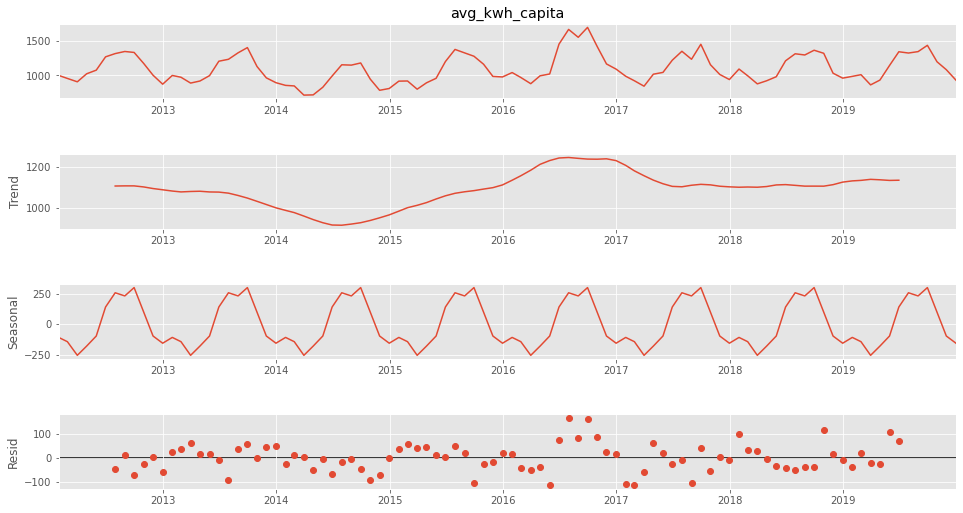

In [21]:
# show seasonal decomposition of consumption with COVID removed

res = sm.tsa.seasonal_decompose(cov_rem,period=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.savefig('images/seas_decomp.png')

<H4>Test diffed data stationarity with an ADF test at c and ctt regression orders</H4>

In [30]:
#ADF-test with diffed data with c regression order for data stationary
yt = cov_rem.diff().dropna()
res = sm.tsa.adfuller(yt ,regression='c')
print('p-value:{}'.format(res[1]))

p-value:0.18560731676936698


In [31]:
#ADF-test with diffed data with ctt regression order for data stationary
yt = cov_rem.diff().dropna()
res = sm.tsa.adfuller(yt, regression='ctt')
print('p-value:{}'.format(res[1]))

p-value:0.6195065182358314


<H4>Test *twice* diffed data stationarity with an ADF test at c and ctt regression orders</H4>

In [32]:
#ADF-test with diffed data with c regression order for data stationary
yt = cov_rem.diff().diff().dropna()
res = sm.tsa.adfuller(yt, regression='c')
print('p-value:{}'.format(res[1]))

p-value:6.707975008719635e-16


In [33]:
#ADF-test with diffed data with ctt regression order for data stationary
yt = cov_rem.diff().diff().dropna()
res = sm.tsa.adfuller(yt,regression='ctt')
print('p-value:{}'.format(res[1]))

p-value:2.991342320644414e-13


<h4>Create twice diffed data with NAs removed</h4>

In [26]:
diffed = cov_rem.diff().diff().dropna()
# diffed = diffed[12:] - diffed[:-12]
diffed.head()

Date
2012-03-31     -5.514781
2012-04-30    166.081658
2012-05-31    -63.723869
2012-06-30    140.591663
2012-07-31   -146.334915
Name: avg_kwh_capita, dtype: float64

<H4>Show seasonal decomposition of the twice diffed data</H4>

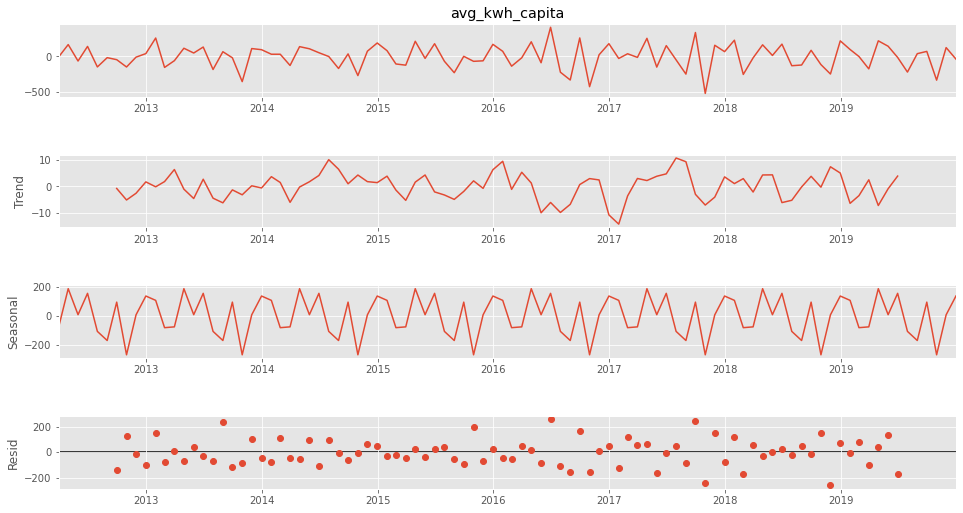

In [27]:
# show seasonal decomposition of consumption with twice diffed and covid removed data

res = sm.tsa.seasonal_decompose(diffed,period=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.savefig('images/diffed_seas_decomp.png')

<H4>Export cleaned and stationary data</H4>

In [28]:
# export stationary data to the stationary data directory for training in another notebook
diffed.to_csv(r'stationary-data/diffed_data.csv', header=True)

<H4>Export cleaned and stationary data</H4>

In [29]:
# export non-stationary data to the stationary data dir for use in inverse differencing after training
cov_rem.to_csv(r'stationary-data/cov_rem.csv', header=True)